In [1]:
from lib.backbone import StackedHGNetV1
from lib.utility import get_dataloader

In [2]:
class Model_Config:
    def __init__(self):
        self.classes_num = [68, 9, 68]
        self.edge_info = (
                (False, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)),  # FaceContour
                (False, (17, 18, 19, 20, 21)),  # RightEyebrow
                (False, (22, 23, 24, 25, 26)),  # LeftEyebrow
                (False, (27, 28, 29, 30)),  # NoseLine
                (False, (31, 32, 33, 34, 35)),  # Nose
                (True, (36, 37, 38, 39, 40, 41)),  # RightEye
                (True, (42, 43, 44, 45, 46, 47)),  # LeftEye
                (True, (48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59)),  # OuterLip
                (True, (60, 61, 62, 63, 64, 65, 66, 67)),  # InnerLip
            )
        self.nstack = 4
        self.add_coord = True
        self.decoder_type = "default"
        self.width = 256
        self.height = 256
        self.use_AAM = True

In [3]:
model_config = Model_Config()
net = StackedHGNetV1(config=model_config,
                        classes_num=model_config.classes_num,
                        edge_info=model_config.edge_info,
                        nstack=model_config.nstack,
                        add_coord=model_config.add_coord,
                        decoder_type=model_config.decoder_type)

In [4]:
net

StackedHGNetV1(
  (pre): Sequential(
    (0): CoordConvTh(
      (addcoords): AddCoordsTh()
      (conv): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu): ReLU()
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (relu): ReLU()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (skip_layer): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size

In [5]:
class Data_Config:
    def __init__(self):
            self.data_definition = "300W"
            self.train_tsv_file = 'pub_annot/300W/train.tsv'
            self.val_tsv_file = 'pub_annot/300W/test.tsv'
            self.train_pic_dir = 'pub_dataset/300W'
            self.val_pic_dir = 'pub_dataset/300W'
            self.loader_type = 'alignment'
            self.batch_size = 16
            self.val_batch_size = 32
            self.train_num_workers = 1
            self.val_num_workers = 1
            self.width = 256
            self.height = 256
            self.channels = 3
            self.means = (127.5, 127.5, 127.5)
            self.scale = 0.00784313725490196
            self.classes_num = [68, 9, 68]
            self.crop_op = True
            self.aug_prob = 1.0
            self.label_num = 12
            self.edge_info = (
                (False, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)),  # FaceContour
                (False, (17, 18, 19, 20, 21)),  # RightEyebrow
                (False, (22, 23, 24, 25, 26)),  # LeftEyebrow
                (False, (27, 28, 29, 30)),  # NoseLine
                (False, (31, 32, 33, 34, 35)),  # Nose
                (True, (36, 37, 38, 39, 40, 41)),  # RightEye
                (True, (42, 43, 44, 45, 46, 47)),  # LeftEye
                (True, (48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59)),  # OuterLip
                (True, (60, 61, 62, 63, 64, 65, 66, 67)),  # InnerLip
            )
            self.flip_mapping = ([0, 16], [1, 15], [2, 14], [3, 13], [4, 12], [5, 11], [6, 10], [7, 9], [17, 26], [18, 25], [19, 24], [20, 23], [21, 22], [31, 35], [32, 34], [36, 45], [37, 44], [38, 43], [39, 42], [40, 47], [41, 46], [48, 54], [49, 53], [50, 52], [61, 63], [60, 64], [67, 65], [58, 56], [59, 55])
            self.encoder_type = 'default'

            # Val
            self.norm_type = 'default'
            self.nme_left_index = 36
            self.nme_right_index = 45


In [6]:
data_config = Data_Config()
train_loader = get_dataloader(data_config, data_type='train', world_rank=0, world_size=1)
val_loader = get_dataloader(data_config, "val")

In [7]:
import numpy as np
import pandas as pd
import cv2
import re
import matplotlib.pyplot as plt
import torch

300W Original Label

In [8]:
train_label = pd.read_csv(data_config.train_tsv_file, sep="\t", header=None)

In [9]:
line = train_label[train_label.iloc[:,0].apply(lambda x: re.search(r'2838782176_1\.jpg',x)!=None)].iloc[0]

In [10]:
def get_label(line):
    image_path = line[0]
    landmarks_5pts = line[1]
    landmarks_5pts = np.array(list(map(float, landmarks_5pts.split(","))), dtype=np.float32).reshape(5, 2)
    landmarks_target = line[2]
    landmarks_target = np.array(list(map(float, landmarks_target.split(","))), dtype=np.float32).reshape(
        data_config.classes_num[0], 2)
    scale = float(line[3])
    center_w, center_h = float(line[4]), float(line[5])
    return image_path,landmarks_5pts,landmarks_target,scale,center_w,center_h

In [11]:
image_path,landmarks_5pts,landmarks_target,scale,center_w,center_h = get_label(line)

In [12]:
img = cv2.imread(image_path.replace('rawImages','pub_dataset/300W'), cv2.IMREAD_COLOR)

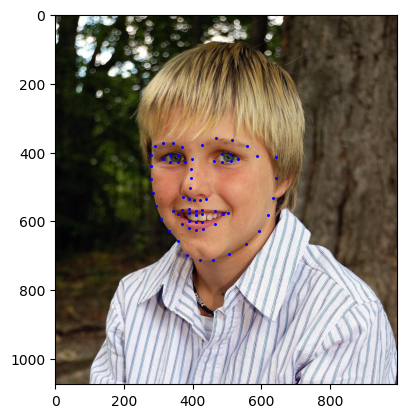

In [13]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(landmarks_target[:,0], landmarks_target[:,1], s=5, marker='.', c='b')

Processed Data

In [14]:
def denorm_points(points, h, w, align_corners=False):
    if align_corners:
        # [-1, +1] -> [0, SIZE-1]
        des_points = (points + 1) / 2 * torch.tensor([w - 1, h - 1]).to(points).view(1, 1, 2)
    else:
        # [-1, +1] -> [-0.5, SIZE-0.5]
        des_points = ((points + 1) * torch.tensor([w, h]).to(points).view(1, 1, 2) - 1) / 2
    return des_points

In [15]:
for batch,sample in enumerate(train_loader):
    break

In [16]:
i = 2
print(sample['data'][i].numpy().shape)
img = sample['data'][i]
len(sample['label']) # landmarks, heatmap, edgemap
landmarks, heatmaps, edgemaps = sample['label']
landmark = landmarks[i]
heatmap = heatmaps[i]
edgemap = edgemaps[i]
matrixs = sample['matrix']
matrix = matrixs[i]

(3, 256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


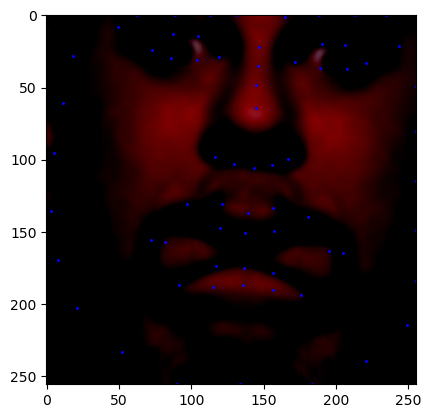

In [17]:
denorm_landmark = denorm_points(landmark,h=256,w=256).squeeze()
ori_img = cv2.cvtColor(img.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB) #'pub_dataset/300W/helen/trainset/2838782176_1.jpg'
plt.imshow(ori_img)
plt.scatter(denorm_landmark[:,0], denorm_landmark[:,1], s=5, marker='.', c='b')

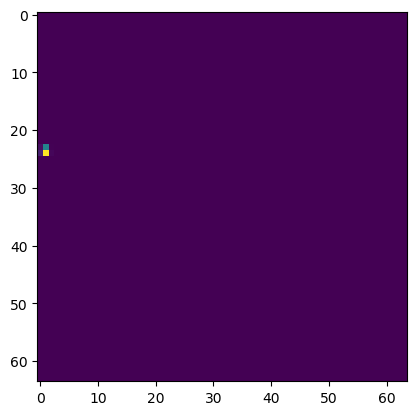

In [18]:
plt.imshow(heatmap[2], cmap='viridis', interpolation='nearest')

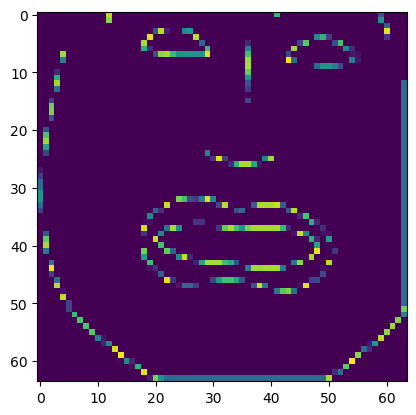

In [19]:
combined_edgemap = np.max(edgemap.numpy(), axis=0)
plt.imshow(combined_edgemap, cmap='viridis', interpolation='nearest')

In [20]:
# output, heatmaps, landmarks = net(sample['data'])
# output: [landmarks, pointmaps, edgemaps ] * nstack


In [21]:

import torch.nn.functional as F
from lib.loss import *
from lib.metric import NME, FR_AUC

In [22]:
class Train_Config:
    def __init__(self):
        # self.classes_num = [68, 9, 68]
        self.nstack = 4
        # self.add_coord = True
        # self.decoder_type = "default"
        # self.width = 256
        # self.height = 256
        self.use_AAM = True
        self.label_num = self.nstack * 3 if self.use_AAM else self.nstack

        self.loss_func = "STARLoss_v2"

        # STAR Loss paras
        self.star_w = 1
        self.star_dist = 'smoothl1'

        self.loss_weights, self.criterion_labels, self.metrics = self.set_criterions()
        self.criterions = self.get_criterions()

        self.batch_weight = 1.0

        self.optimizer = "adam"
        self.learn_rate = 0.001
        self.weight_decay = 0.00001
        self.betas = [0.9, 0.999]
        self.gamma = 0.9
        self.milestones = [10*i for i in range(2,10)]

    def set_criterions(self):
        loss_weights, criterions, metrics = [], [], []
        for i in range(self.nstack):
            factor = (2 ** i) / (2 ** (self.nstack - 1))
            if self.use_AAM:
                loss_weights += [factor * weight for weight in [1.0, 10.0, 10.0]]
                criterions += [self.loss_func, "AWingLoss", "AWingLoss"]
                metrics += ["NME", None, None]
            else:
                loss_weights += [factor * weight for weight in [1.0]]
                criterions += [self.loss_func, ]
                metrics += ["NME", ]
        return loss_weights, criterions, metrics
    
    def get_criterions(self):
        criterions = []
        for k in range(self.label_num):
            label = self.criterion_labels[k]
            if label == "AWingLoss":
                criterion = AWingLoss()
            elif label == "smoothl1":
                criterion = SmoothL1Loss()
            elif label == "l1":
                criterion = F.l1_loss
            elif label == 'l2':
                criterion = F.mse_loss
            elif label == "STARLoss":
                criterion = STARLoss(dist=self.star_dist, w=self.star_w)
            elif label == "STARLoss_v2":
                criterion = STARLoss_v2(dist=self.star_dist, w=self.star_w)
            else:
                assert False
            criterions.append(criterion)
        return criterions

In [23]:
train_config = Train_Config()

In [24]:
import lightning as L
from lib.metric import NME, FR_AUC

In [35]:

# define the LightningModule
class LitSTAR(L.LightningModule):
    def __init__(self, net, data_config, model_config, train_config):
        super().__init__()
        self.net = net
        self.data_config = data_config
        self.model_config = model_config
        self.train_config = train_config
        self.ave_losses = [0] * self.train_config.label_num
        self.list_nmes = [[] for i in range(self.data_config.label_num)]
        
    def training_step(self, sample, batch_idx):

        imgs = sample["data"].float()

        labels = []
        if isinstance(sample["label"], list):
            for label in sample["label"]:
                label = label.float()
                labels.append(label)
        else:
            label = sample["label"].float()
            for k in range(label.shape[1]):
                labels.append(label[:, k])
        labels = self.model_config.nstack * labels

        # forward
        output, heatmaps, landmarks = self.net(imgs)


        losses, sum_loss = self.compute_loss(output, labels, heatmaps, landmarks)
        self.ave_losses = list(map(sum, zip(self.ave_losses, losses)))
        avg_loss = sum(losses) / len(losses)
        # Logging to TensorBoard (if installed) by default
        self.log("sum_loss", sum_loss, prog_bar=True)
        self.log("AVG_loss",avg_loss,prog_bar=True)
        return sum_loss
    
    def validation_step(self,sample,batch_idx):
        
        metric_nme = NME(nme_left_index=self.data_config.nme_left_index, nme_right_index=self.data_config.nme_right_index)
        metric_fr_auc = FR_AUC(data_definition=self.data_config.data_definition)

        output_pd = None

        imgs = sample["data"].float()

        labels = []
        if isinstance(sample["label"], list):
            for label in sample["label"]:
                label = label.float()
                labels.append(label)
        else:
            label = sample["label"].float()
            for k in range(label.shape[1]):
                labels.append(label[:, k])
        labels = self.model_config.nstack * labels

        # forward
        output, heatmaps, landmarks = self.net(imgs)

        for k in range(self.data_config.label_num):
            if self.train_config.metrics[k] is not None:
                self.list_nmes[k] += metric_nme.test(output[k], labels[k])

    def on_validation_epoch_end(self):
        metric_nme = NME(nme_left_index=self.data_config.nme_left_index, nme_right_index=self.data_config.nme_right_index)
        metric_fr_auc = FR_AUC(data_definition=self.data_config.data_definition)
        metrics = [[torch.mean(torch.tensor(nmes)), ] + metric_fr_auc.test(torch.tensor(nmes)) for nmes in self.list_nmes]

        # self.log("Val_metrics",metrics)
        for k, metric in enumerate(metrics):
            nme, fr, auc = metric
            # print(metric)
            if not torch.isnan(nme):
                stack_no = k//3
                self.log(f"Stack{stack_no}_NME",nme,on_epoch=True)
                self.log(f"Stack{stack_no}_FR",fr,on_epoch=True)
                self.log(f"Stack{stack_no}_AUC",auc,on_epoch=True)
                # print("Val/Metric{:3d} in this epoch: [NME {:.6f}, FR {:.6f}, AUC {:.6f}]".format(
                #     k, metric[0], metric[1], metric[2]))

        self.list_nmes = [[] for i in range(self.data_config.label_num)]


    def compute_loss(self, output, labels, heatmap=None, landmarks=None):
        batch_weight = self.train_config.batch_weight
        sum_loss = 0
        losses = list()
        # print(self.train_config.criterion_labels)
        for k in range(self.train_config.label_num):
            
            if self.train_config.criterion_labels[k] in ['smoothl1', 'l1', 'l2', 'WingLoss', 'AWingLoss']:
                loss = self.train_config.criterions[k](output[k], labels[k])
            elif self.train_config.criterion_labels[k] in ["STARLoss", "STARLoss_v2"]:
                _k = int(k / 3) if self.train_config.use_AAM else k
                loss = self.train_config.criterions[k](heatmap[_k], labels[k])
            else:
                assert NotImplementedError
            loss = batch_weight * loss
            sum_loss += self.train_config.loss_weights[k] * loss
            losses.append(loss)
        return losses, sum_loss

    def configure_optimizers(self):
        params = self.net.parameters()

        optimizer = None
        if self.train_config.optimizer == "sgd":
            optimizer = torch.optim.SGD(
                params,
                lr=self.train_config.learn_rate,
                momentum=self.train_config.momentum,
                weight_decay=self.train_config.weight_decay,
                nesterov=self.train_config.nesterov)
        elif self.train_config.optimizer == "adam":
            optimizer = torch.optim.Adam(
                params,
                lr=self.train_config.learn_rate)
        elif self.train_config.optimizer == "rmsprop":
            optimizer = torch.optim.RMSprop(
                params,
                lr=self.train_config.learn_rate,
                momentum=self.train_config.momentum,
                alpha=self.train_config.alpha,
                eps=self.train_config.epsilon,
                weight_decay=self.train_config.weight_decay
            )
        else:
            assert False

        config_dict = {
            "optimizer" : optimizer,
            "lr_scheduler" : {
                "scheduler" : torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.train_config.milestones, gamma=self.train_config.gamma)
            }
        }
        return config_dict


# init the module
STAR = LitSTAR(net, data_config, model_config, train_config)

In [36]:
from lightning.pytorch.callbacks import LearningRateMonitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [37]:
ckpt_path = "lightning_logs/version_10/checkpoints/epoch=62-step=12411.ckpt"
if ckpt_path is not None:
    STAR = LitSTAR.load_from_checkpoint(ckpt_path,
    net = net, 
    data_config = data_config, 
    model_config = model_config,
    train_config = train_config)

In [38]:
# Pretrained Model
# model_path = "300W_STARLoss_NME_2_87.pkl"
# checkpoint = torch.load(model_path)
# STAR.net.load_state_dict(checkpoint["net"])

/tmp/ipykernel_18052/2070701826.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


<All keys matched successfully>

In [39]:
trainer = L.Trainer(
    max_epochs=100,
    limit_train_batches = 1,
    log_every_n_steps=1,
    callbacks=[lr_monitor],
    )
trainer.fit(
    model=STAR, 
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
    # ckpt_path=ckpt_path
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type           | Params | Mode 
------------------------------------------------
0 | net  | StackedHGNetV1 | 17.1 M | train
------------------------------------------------
17.1 M    Trainable params
0         Non-trainable params
17.1 M    Total params
68.278    Total estimated model params size (MB)
916       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

DEMO

In [75]:
import dlib
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [42]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)

In [108]:
face_file_path = 'pub_dataset/WFLW/WFLW_images/8--Election_Campain/8_Election_Campain_Election_Campaign_8_25.jpg'
image = cv2.imread(face_file_path)

In [ ]:
class GetCropMatrix():
    """
    from_shape -> transform_matrix
    """

    def __init__(self, image_size, target_face_scale, align_corners=False):
        self.image_size = image_size
        self.target_face_scale = target_face_scale
        self.align_corners = align_corners

    def _compose_rotate_and_scale(self, angle, scale, shift_xy, from_center, to_center):
        cosv = math.cos(angle)
        sinv = math.sin(angle)

        fx, fy = from_center
        tx, ty = to_center

        acos = scale * cosv
        asin = scale * sinv

        a0 = acos
        a1 = -asin
        a2 = tx - acos * fx + asin * fy + shift_xy[0]

        b0 = asin
        b1 = acos
        b2 = ty - asin * fx - acos * fy + shift_xy[1]

        rot_scale_m = np.array([
            [a0, a1, a2],
            [b0, b1, b2],
            [0.0, 0.0, 1.0]
        ], np.float32)
        return rot_scale_m

    def process(self, scale, center_w, center_h):
        if self.align_corners:
            to_w, to_h = self.image_size - 1, self.image_size - 1
        else:
            to_w, to_h = self.image_size, self.image_size

        rot_mu = 0
        scale_mu = self.image_size / (scale * self.target_face_scale * 200.0)
        shift_xy_mu = (0, 0)
        matrix = self._compose_rotate_and_scale(
            rot_mu, scale_mu, shift_xy_mu,
            from_center=[center_w, center_h],
            to_center=[to_w / 2.0, to_h / 2.0])
        return matrix


class TransformPerspective():
    """
    image, matrix3x3 -> transformed_image
    """

    def __init__(self, image_size):
        self.image_size = image_size

    def process(self, image, matrix):
        return cv2.warpPerspective(
            image, matrix, dsize=(self.image_size, self.image_size),
            flags=cv2.INTER_LINEAR, borderValue=0)


class TransformPoints2D():
    """
    points (nx2), matrix (3x3) -> points (nx2)
    """

    def process(self, srcPoints, matrix):
        # nx3
        desPoints = np.concatenate([srcPoints, np.ones_like(srcPoints[:, [0]])], axis=1)
        desPoints = desPoints @ np.transpose(matrix)  # nx3
        desPoints = desPoints[:, :2] / desPoints[:, [2, 2]]
        return desPoints.astype(srcPoints.dtype)


class Alignment:
    def __init__(self, model):
        self.input_size = 256
        self.target_face_scale = 1.0

        self.model =model
        self.model.eval()
        self.getCropMatrix = GetCropMatrix(image_size=self.input_size, target_face_scale=self.target_face_scale,
                                           align_corners=True)
        self.transformPerspective = TransformPerspective(image_size=self.input_size)
        self.transformPoints2D = TransformPoints2D()

    def norm_points(self, points, align_corners=False):
        if align_corners:
            # [0, SIZE-1] -> [-1, +1]
            return points / torch.tensor([self.input_size - 1, self.input_size - 1]).to(points).view(1, 1, 2) * 2 - 1
        else:
            # [-0.5, SIZE-0.5] -> [-1, +1]
            return (points * 2 + 1) / torch.tensor([self.input_size, self.input_size]).to(points).view(1, 1, 2) - 1

    def denorm_points(self, points, align_corners=False):
        if align_corners:
            # [-1, +1] -> [0, SIZE-1]
            return (points + 1) / 2 * torch.tensor([self.input_size - 1, self.input_size - 1]).to(points).view(1, 1, 2)
        else:
            # [-1, +1] -> [-0.5, SIZE-0.5]
            return ((points + 1) * torch.tensor([self.input_size, self.input_size]).to(points).view(1, 1, 2) - 1) / 2

    def preprocess(self, image, scale, center_w, center_h):
        matrix = self.getCropMatrix.process(scale, center_w, center_h)
        input_tensor = self.transformPerspective.process(image, matrix)
        input_tensor = input_tensor[np.newaxis, :]

        input_tensor = torch.from_numpy(input_tensor)
        input_tensor = input_tensor.float().permute(0, 3, 1, 2)
        input_tensor = input_tensor / 255.0 * 2.0 - 1.0
        # input_tensor = input_tensor.to(self.model.device)
        return input_tensor, matrix

    def postprocess(self, srcPoints, coeff):
        # dstPoints = self.transformPoints2D.process(srcPoints, coeff)
        # matrix^(-1) * src = dst
        # src = matrix * dst
        dstPoints = np.zeros(srcPoints.shape, dtype=np.float32)
        for i in range(srcPoints.shape[0]):
            dstPoints[i][0] = coeff[0][0] * srcPoints[i][0] + coeff[0][1] * srcPoints[i][1] + coeff[0][2]
            dstPoints[i][1] = coeff[1][0] * srcPoints[i][0] + coeff[1][1] * srcPoints[i][1] + coeff[1][2]
        return dstPoints

    def analyze(self, image, scale, center_w, center_h):
        input_tensor, matrix = self.preprocess(image, scale, center_w, center_h)


        with torch.no_grad():
            output = self.model(input_tensor)
        landmarks = output[-1][0]

        landmarks = self.denorm_points(landmarks)
        landmarks = landmarks.data.cpu().numpy()[0]
        landmarks = self.postprocess(landmarks, np.linalg.inv(matrix))

        return landmarks



In [110]:
alignment = Alignment(model=STAR.net)

In [111]:
dets = detector(image, 1)
for detection in dets:
    face = sp(image,detection)
    shape = []
    for i in range(68):
        x = face.part(i).x
        y = face.part(i).y
        shape.append((x, y))
    shape = np.array(shape)
    # image_draw = draw_pts(image_draw, shape)
    x1, x2 = shape[:, 0].min(), shape[:, 0].max()
    y1, y2 = shape[:, 1].min(), shape[:, 1].max()
    scale = min(x2 - x1, y2 - y1) / 200 * 1.05
    center_w = (x2 + x1) / 2
    center_h = (y2 + y1) / 2

    scale, center_w, center_h = float(scale), float(center_w), float(center_h)

    landmarks_pv = alignment.analyze(image, scale, center_w, center_h)

Number of faces detected: 1
Detection 0: Left: 572 Top: 201 Right: 758 Bottom: 387


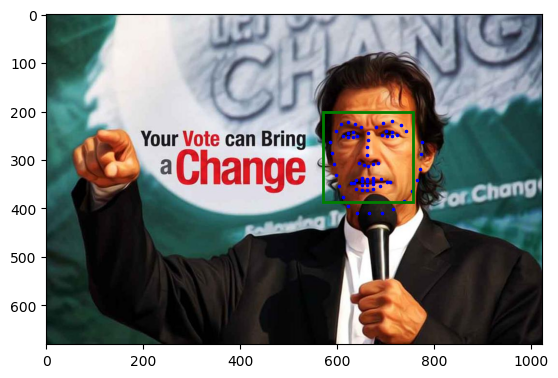

In [112]:
img = image.copy()
landmarks = landmarks_pv
print("Number of faces detected: {}".format(len(dets)))
for k, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        k, d.left(), d.top(), d.right(), d.bottom()))
    # Get the landmarks/parts for the face in box d.
    d_left = d.left()
    d_top = d.top()
    d_right = d.right()
    d_bottom = d.bottom()

    x = d_left
    y = d_top
    w = d_right - d_left
    h = d_bottom - d_top
    
    bbox = (x, y, w, h)
    # output = predictor.inference(img, [bbox])
    # # Draw the face landmarks on the screen.
    # landmarks = np.array(output['landmarks']).squeeze()
    
    x, y, w, h = map(int, bbox)

    fig, ax = plt.subplots(1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Display the image
    ax.imshow(img)
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c='b')
    plt.show()